<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/huggingface-rag-cookbook/semi_structured_and_multi_modal_RAG_part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Semi-structured and Multi-modal RAG


Many documents contain a mixture of content types, including text, tables, and images.

Semi-structured data can be challenging for conventional RAG for at least two reasons:

* Text splitting may break up tables, corrupting the data in retrieval
* Embedding tables may pose challenges for semantic similarity search

And the information captured in images is typically lost.

With the emergence of multimodal LLMs, like [GPT4-V](https://openai.com/research/gpt-4v-system-card), it is worth considering how to utilize images in RAG:

`Option 1:`

* Use multimodal embeddings (such as [CLIP](https://openai.com/research/clip)) to embed images and text
* Retrieve both using similarity search
* Pass raw images and text chunks to a multimodal LLM for answer synthesis

`Option 2:`

* Use a multimodal LLM (such as [GPT4-V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve text
* Pass text chunks to an LLM for answer synthesis

`Option 3:`

* Use a multimodal LLM (such as [GPT4-V](https://openai.com/research/gpt-4v-system-card), [LLaVA](https://llava.hliu.cc/), or [FUYU-8b](https://www.adept.ai/blog/fuyu-8b)) to produce text summaries from images
* Embed and retrieve image summaries with a reference to the raw image
* Pass raw images and text chunks to a multimodal LLM for answer synthesis   

This cookbook show how we might tackle this :

* We will use [Unstructured](https://unstructured.io/) to parse images, text, and tables from documents (PDFs).
* We will use the [multi-vector retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector) to store raw tables, text, (optionally) images along with their summaries for retrieval.
* We will demonstrate `Option 2`, and will follow-up on the other approaches in future cookbooks.

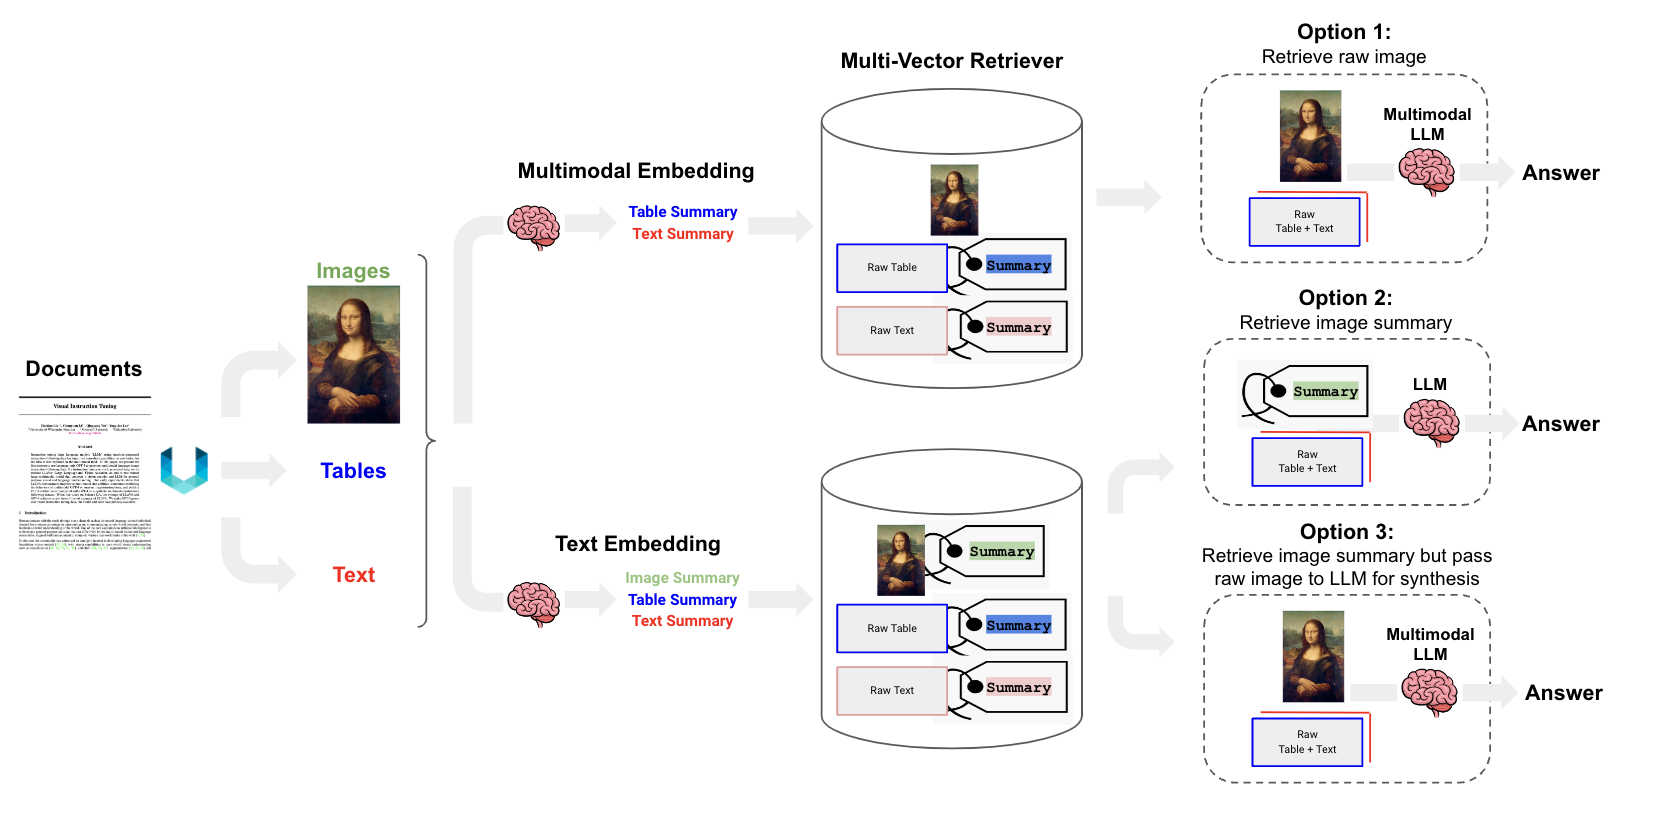

## Setup

In [1]:
%%capture

!pip install langchain unstructured[all-docs] pydantic lxml
!pip install torch transformers accelerate bitsandbytes sentence-transformers chromadb langchain_community

In [ ]:
!sudo apt install tesseract-ocr
!apt-get install poppler-utils

In [ ]:
!pip install tesseract
!pip install pytesseract

In [1]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = (r'/usr/bin/tesseract')

## Data Loading

### Partition PDF tables, text, and images
  
* `LLaVA` Paper: https://arxiv.org/pdf/2304.08485.pdf
* Use [Unstructured](https://unstructured-io.github.io/unstructured/) to partition elements

In [ ]:
!wget https://arxiv.org/pdf/2304.08485.pdf

!mv 2304.08485.pdf LLaVA.pdf

In [3]:
path = "/content/"

In [ ]:
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

# Get elements
raw_pdf_elements = partition_pdf(
    filename=path + "LLaVA.pdf",
    # Using pdf format to find embedded image blocks
    extract_images_in_pdf=True,
    # Use layout model (YOLOX) to get bounding boxes (for tables) and find titles
    # Titles are any sub-section of the document
    infer_table_structure=True,
    # Post processing to aggregate text once we have the title
    chunking_strategy="by_title",
    # Chunking params to aggregate text blocks
    # Attempt to create a new chunk 3800 chars
    # Attempt to keep chunks > 2000 chars
    # Hard max on chunks
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

In [5]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 31,
 "<class 'unstructured.documents.elements.Table'>": 4}

In [6]:
class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

4
31


## Model Setup

In [ ]:
from langchain.llms import HuggingFacePipeline
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

In [ ]:
model_name = "meta-llama/Meta-Llama-3-8B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(model_name)

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    do_sample=True,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=200,
    eos_token_id=terminators,
)

model = HuggingFacePipeline(pipeline=text_generation_pipeline)

## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary).

Summaries are used to retrieve raw tables and / or raw chunks of text.

### Text and Table summaries

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
# model = ChatOpenAI(temperature=0, model="gpt-4")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [ ]:
# Apply to text
texts = [i.text for i in text_elements]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

In [ ]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

### Image summaries

We will implement `Option 2` discussed above:

* Use a multimodal LLM ([LLaVA](https://llava.hliu.cc/)) to produce text summaries from images
* Embed and retrieve text
* Pass text chunks to an LLM for answer synthesis

**Image summaries**

We will use [LLaVA](https://github.com/haotian-liu/LLaVA/), an open source multimodal model.

https://huggingface.co/docs/transformers/en/model_doc/llava

In [7]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

In [ ]:
from transformers import pipeline

model_id = "llava-hf/llava-1.5-7b-hf"

llava_pipeline = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

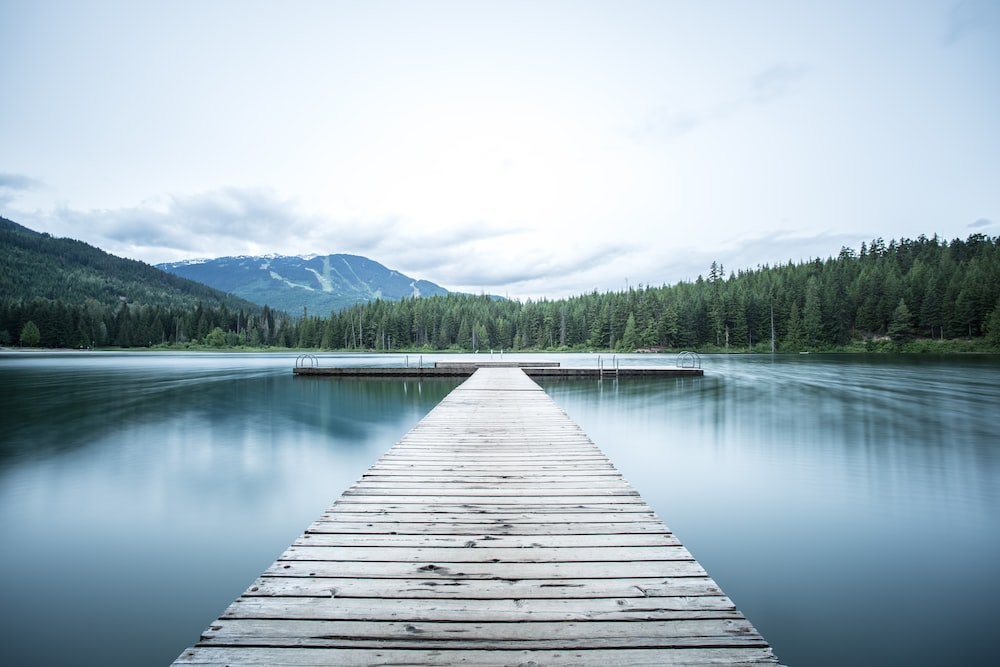

In [9]:
import requests
from PIL import Image

image_url = "https://llava-vl.github.io/static/images/view.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
image

In [ ]:
max_new_tokens = 200
prompt = "USER: <image>\nWhat are the things I should be cautious about when I visit this place?\nASSISTANT:"

outputs = llava_pipeline(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

In [12]:
print(outputs[0]["generated_text"])

USER:  
What are the things I should be cautious about when I visit this place?
ASSISTANT: When visiting this place, which is a pier or dock extending over a body of water, there are a few things to be cautious about. First, be aware of the weather conditions, as sudden changes in weather can make the pier unsafe to walk on. Second, be mindful of the water depth and any potential hazards, such as submerged rocks or debris, that could cause accidents or injuries. Additionally, be cautious of the presence of wildlife, such as birds or fish, and avoid disturbing their natural habitats. Lastly, be aware of any local regulations or guidelines for the use of the pier, as some areas may be restricted or prohibited for certain activities.


In [26]:
!mkdir image_summaries

In [27]:
import os

prompt = "USER: <image>\nDescribe the image in detail. Be specific about graphs, such as bar plots.\nASSISTANT:"
img_path = "figures"
img_summary_path = "image_summaries"
for img in os.listdir(img_path):
  file_name = os.path.splitext(os.path.basename(img))[0]
  # print(file_name)
  image = Image.open(os.path.join(img_path, img))
  outputs = llava_pipeline(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
  # print(outputs[0]["generated_text"])
  with open(f"{img_summary_path}/{file_name}.txt", "w") as f:
    f.write(outputs[0]["generated_text"])

figure-16-7
USER:  
Describe the image in detail. Be specific about graphs, such as bar plots.
ASSISTANT: The image features a computer screen with two different websites displayed. The first website is titled "My Joke Website," while the second one is called "Punchline." The second website is displayed on the right side of the screen.

There are several buttons on the screen, with one button located in the top left corner, another in the top right corner, and a third one in the bottom right corner. The buttons seem to be related to the websites displayed on the screen.
figure-4-2
USER:  
Describe the image in detail. Be specific about graphs, such as bar plots.
ASSISTANT: The image displays a graph with a bar plot, which shows the relationship between language response and the time it takes to respond. The graph is labeled with various terms, such as "image," "h," "x," and "q." The bar plot is divided into sections, with each section representing a different aspect of the language res

After running the above, we  fetch and clean image summaries.

In [ ]:
import glob
import os

# Get all .txt file summaries
# file_paths = glob.glob(os.path.expanduser(os.path.join(path, "*.txt")))

# Read each file and store its content in a list
img_summaries = []
for file_path in os.listdir(img_summary_path):
    with open(f"{img_summary_path}/{file_path}", "r") as file:
        img_summaries.append(file.read())

# Remove any logging prior to summary
# logging_header = "clip_model_load: total allocated memory: 201.27 MB\n\n"
# cleaned_img_summary = [s.split(logging_header, 1)[1].strip() for s in img_summaries]

In [36]:
img_summaries

['USER:  \nDescribe the image in detail. Be specific about graphs, such as bar plots.\nASSISTANT: The image features a garage with a truck parked inside. There are several people in the garage, with some standing closer to the truck and others further away. A backpack is placed on the ground, and a handbag is also visible in the scene.\n\nThe garage has a few other objects, such as a suitcase and a chair. There is also a sports ball located in the middle of the scene. The overall atmosphere of the image suggests a casual gathering or event taking place in the garage.',
 'USER:  \nDescribe the image in detail. Be specific about graphs, such as bar plots.\nASSISTANT: The image features a dining table with a variety of foods and bowls. There are several bowls placed on the table, with one large bowl taking up a significant portion of the table. The bowl appears to be filled with noodles, and it is accompanied by other bowls containing different foods.\n\nIn addition to the bowls, there ar

### Add to vectorstore

Use [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) with summaries.

In [ ]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

For `option 2` (above):

* Store the image summary in the `docstore`, which we return to the LLM for answer generation.

In [ ]:
# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in cleaned_img_summary]
summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(cleaned_img_summary)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, cleaned_img_summary)))

For `option 3` (above):

* Store the images in the `docstore`.
* Using the image in answer synthesis will require a multimodal LLM with Python API integration.
* GPT4-V is expected soon, and - as mentioned above - CLIP support is likely to be added to `llama.cpp` in the future.

In [ ]:
# Add images
img_ids = [str(uuid.uuid4()) for _ in cleaned_img_summary]
summary_img = [
    Document(page_content=s, metadata={id_key: img_ids[i]})
    for i, s in enumerate(cleaned_img_summary)
]
retriever.vectorstore.add_documents(summary_img)
### Fetch images
retriever.docstore.mset(
    list(
        zip(
            img_ids,
        )
    )
)

### Sanity Check retrieval

The most complex table in the paper:

In [ ]:
tables[2]

'Subject Context Modality Grade Method NAT SOC LAN | TXT IMG NO | Gi6~ G7-12 | Average Representative & SoTA methods with numbers reported in the literature Human [30] 90.23 84.97 87.48 | 89.60 87.50 88.10 | 91.59 82.42 88.40 GPT-3.5 [30] 74.64 69.74 76.00 | 74.44 67.28 77.42 | 76.80 68.89 73.97 GPT-3.5 w/ CoT [30] 75.44 70.87 78.09 | 74.68 67.43 79.93 | 78.23 69.68 75.17 LLaMA-Adapter [55] 84.37 88.30 84.36 | 83.72 80.32 86.90 | 85.83 84.05 85.19 MM-CoT gase [57] 87.52 77.17 85.82 | 87.88 82.90 86.83 | 84.65 85.37 84.91 MM-CoT farge [57] 95.91 82.00 90.82 | 95.26 88.80 92.89 | 92.44 90.31 | 91.68 Results with our own experiment runs GPT-4 84.06 73.45 87.36 | 81.87 70.75 90.73 | 84.69 79.10 82.69 LLaVA 90.36 95.95 88.00 | 89.49 88.00 90.66 | 90.93 90.90 90.92 LLaVA+GPT-4 (complement) 90.36 95.50 88.55 | 89.05 87.80 91.08 | 92.22 88.73 90.97 LLaVA+GPT-4 (judge) 91.56 96.74 91.09 | 90.62 88.99 93.52 | 92.73 92.16 92.53'

Here is the summary, which is embedded:

In [ ]:
table_summaries[2]

'The table presents the performance of various methods in different subject contexts and modalities. The subjects are Natural Sciences (NAT), Social Sciences (SOC), and Language (LAN). The modalities are text (TXT), image (IMG), and no modality (NO). The methods include Human, GPT-3.5, GPT-3.5 with CoT, LLaMA-Adapter, MM-CoT gase, MM-CoT farge, GPT-4, LLaVA, LLaVA+GPT-4 (complement), and LLaVA+GPT-4 (judge). The performance is measured in grades from 6 to 12. The MM-CoT farge method had the highest performance in most categories, with LLaVA+GPT-4 (judge) showing the highest results in the experiment runs.'

Here is our retrieval of that table from the natural language query:

In [ ]:
# We can retrieve this table
retriever.invoke("What are results for LLaMA across across domains / subjects?")[1]

'Subject Context Modality Grade Method NAT SOC LAN | TXT IMG NO | Gi6~ G7-12 | Average Representative & SoTA methods with numbers reported in the literature Human [30] 90.23 84.97 87.48 | 89.60 87.50 88.10 | 91.59 82.42 88.40 GPT-3.5 [30] 74.64 69.74 76.00 | 74.44 67.28 77.42 | 76.80 68.89 73.97 GPT-3.5 w/ CoT [30] 75.44 70.87 78.09 | 74.68 67.43 79.93 | 78.23 69.68 75.17 LLaMA-Adapter [55] 84.37 88.30 84.36 | 83.72 80.32 86.90 | 85.83 84.05 85.19 MM-CoT gase [57] 87.52 77.17 85.82 | 87.88 82.90 86.83 | 84.65 85.37 84.91 MM-CoT farge [57] 95.91 82.00 90.82 | 95.26 88.80 92.89 | 92.44 90.31 | 91.68 Results with our own experiment runs GPT-4 84.06 73.45 87.36 | 81.87 70.75 90.73 | 84.69 79.10 82.69 LLaVA 90.36 95.95 88.00 | 89.49 88.00 90.66 | 90.93 90.90 90.92 LLaVA+GPT-4 (complement) 90.36 95.50 88.55 | 89.05 87.80 91.08 | 92.22 88.73 90.97 LLaVA+GPT-4 (judge) 91.56 96.74 91.09 | 90.62 88.99 93.52 | 92.73 92.16 92.53'

Image:

![figure-8-1.jpg](attachment:5d505f36-17e1-4fe5-a405-f01f7a392716.jpg)

We can retrieve this image summary:

In [ ]:
retriever.invoke("Images / figures with playful and creative examples")[1]

'The image features a close-up of a tray filled with various pieces of fried chicken. The chicken pieces are arranged in a way that resembles a map of the world, with some pieces placed in the shape of continents and others as countries. The arrangement of the chicken pieces creates a visually appealing and playful representation of the world, making it an interesting and creative presentation.\n\nmain: image encoded in   865.20 ms by CLIP (    1.50 ms per image patch)'

## RAG

Run [RAG pipeline](https://python.langchain.com/docs/expression_language/cookbook/retrieval).

For `option 1` (above):

* Simply pass retrieved text chunks to LLM, as usual.

For `option 2a` (above):

* We would pass retrieved image and images to the multi-modal LLM.
* This should be possible soon, once [llama-cpp-python add multi-modal support](https://github.com/abetlen/llama-cpp-python/issues/813).
* And, of course, this will be enabled by GPT4-V API.

In [ ]:
from langchain_core.runnables import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# Option 1: LLM
model = ChatOpenAI(temperature=0, model="gpt-4")
# Option 2: Multi-modal LLM
# model = GPT4-V or LLaVA

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
chain.invoke(
    "What is the performance of LLaVa across across multiple image domains / subjects?"
)

'The performance of LLaMA across multiple image domains/subjects is as follows: In the Natural Science (NAT) subject, it scored 84.37. In the Social Science (SOC) subject, it scored 88.30. In the Language Science (LAN) subject, it scored 84.36. In the Text Context (TXT) subject, it scored 83.72. In the Image Context (IMG) subject, it scored 80.32. In the No Context (NO) subject, it scored 86.90. For grades 1-6 (G1-6), it scored 85.83 and for grades 7-12 (G7-12), it scored 84.05. The average score was 85.19.'

We can check the [trace](https://smith.langchain.com/public/85a7180e-0dd1-44d9-996f-6cb9c6f53205/r) to see retrieval of tables and text.

In [ ]:
chain.invoke("Explain images / figures with playful and creative examples.")

'The text provides an example of a playful and creative image. The image features a close-up of a tray filled with various pieces of fried chicken. The chicken pieces are arranged in a way that resembles a map of the world, with some pieces placed in the shape of continents and others as countries. The arrangement of the chicken pieces creates a visually appealing and playful representation of the world, making it an interesting and creative presentation.'